# Inductive coding of Reddit data
*This notebook is part of the [LLMCode library](https://github.com/PerttuHamalainen/LLMCode).*

*A note on data privacy: The user experience of this notebook is better on Google Colab, but if you are processing data that cannot be sent to Google and OpenAI servers, you should run this notebook locally using the "Aalto" LLM API.*

**Learning goals**

In this notebook, you'll learn to utilize LLMs to code qualitative data inductively, as well as how to evaluate the human-likeness of the output.

**How to use this Colab notebook?**
* Select the LLM API as well as the GPT and embedding models to use below. The default values are recommended, but some of the examples may produce better quality results using the more expensive "gpt-4o" model. For details about the models, see [OpenAI documentation](https://platform.openai.com/docs/models).
* Select "Run all" from the Runtime menu above.
* Enter your API key below when prompted. This will be provided to you at the workshop. You can also create your own OpenAI account at https://platform.openai.com/signup. The initial free quota you get with the account should be enough for the exercises of this notebook. To create an API key, follow [OpenAI's instructions](https://help.openai.com/en/articles/4936850-where-do-i-find-my-openai-api-key)
* Proceed top-down following the instructions

**New to Colab notebooks?**

Colab notebooks are browser-based learning environments consisting of *cells* that include either text or code. The code is executed in a Google virtual machine instead of your own computer. You can run code cell-by-cell (click the "play" symbol of each code cell), and selecting "Run all" as instructed above is usually the first step to verify that everything works. For more info, see Google's [Intro video](https://www.youtube.com/watch?v=inN8seMm7UI) and [curated example notebooks](https://colab.google/notebooks/).


In [1]:
#Initial setup code. If you opened this notebook in Colab, this code is hidden
#by default to avoid unnecessary user interface clutter

#-------------------------------------------------------
#User-defined parameters. You can freely edit the values
llm_API="OpenAI" # @param ["OpenAI", "Aalto"]
gpt_model="gpt-4o-mini" #@param ["gpt-4o-mini","gpt-4o"]
embedding_model = "text-embedding-3-small" #@param ["text-embedding-ada-002","text-embedding-3-small", "text-embedding-3-large"]

#-------------------------------------------------------------------
#Implementation. Only edit this part if you know what your are doing

#Import packages
import pandas as pd
import numpy as np
from IPython.display import HTML, Markdown, display, clear_output
import getpass
import os
import html
import lxml
import re
import plotly.graph_objects as go
import plotly.express as px
import textwrap
import random
import math
from collections import Counter, defaultdict

original_dir = os.getcwd()

#determine if we are running in Colab
import sys
RunningInCOLAB = 'google.colab' in sys.modules
if RunningInCOLAB:
  from google.colab import files
  import plotly.io as pio
  pio.renderers.default = "colab"
  if not os.path.exists("LLMCode"):
    if not os.getcwd().endswith("LLMCode"):
      print("Cloning the LLMCode repository...")
      #until the repo is public, we download this working copy instead of cloning
      #(shared as: anyone with the link can view)
      #!wget "https://drive.google.com/uc?export=download&id=1ylMQn96JuKBB-YU9mHLyEhtm6Qin1Kgh" -O LLMCode.zip
      #!mkdir LLMCode
      #!unzip -q LLMCode.zip -d LLMCode
      !git clone https://github.com/PerttuHamalainen/LLMCode.git
  if not os.getcwd().endswith("LLMCode"):
    os.chdir("LLMCode")
    print("Installing dependencies...")
    !pip install -r requirements_notebooks.txt
import llmcode

os.chdir(original_dir)

#Jupyter is already running an asyncio event loop => need this hack for async OpenAI API calling
import nest_asyncio
nest_asyncio.apply()

#Prompt the user for an API key if not provided via a system variable
clear_output()
if llm_API=="OpenAI":
    if os.environ.get("OPENAI_API_KEY") is None:
        print("Please input an OpenAI API key")
        api_key = getpass.getpass()
        os.environ["OPENAI_API_KEY"] = api_key
elif llm_API=="Aalto":
    if os.environ.get("AALTO_OPENAI_API_KEY") is None:
        print("Please input an Aalto OpenAI API key")
        api_key = getpass.getpass()
        os.environ["AALTO_OPENAI_API_KEY"] = api_key
else:
    print(f"Invalid API type: {llm_API}")

#Initialize the LLMCode library
llmcode.init(API=llm_API)
llmcode.set_cache_directory("data_exploration_cache")

Please input an OpenAI API key


 ········


# Qualitative coding

Qualitative coding involves the analysis of texts through highlighting relevant parts of the text and assigning each highlight a code or a set of codes that communicate its relevance to the research. For example, using an excerpt from the [Games As Art](https://osf.io/ryvt6/) research project as an example, a coded text may look like the following:

> When you take in consideration **the music, the graphic design, the writing, and of course the gameplay**<sup>audio; visuals; narrative</sup>. Its in games like this when you are aware of be **playing an artwork, rather than just another game**<sup>comparison to conventional art forms</sup>.

In this example, the text has been annotated with two highlights that have been assigned the codes _audio_, _visuals_, _narrative_ (for the first highlight), and _comparison to conventional art forms_ (for the second highlight).

In this notebook, we accept files that have been coded using Microsoft Word. Make sure that the file is formatted according to the following requirements:
* Individual texts are separated by five dashes "-----"
* The texts are coded using [Word comments](https://support.microsoft.com/en-us/office/using-modern-comments-8d3f868a-867e-4df2-8c68-bf96671641e2) by highlighting the relevant part and typing the code(s) in the comment field. Multiple codes are separated by a semicolon ";".

While LLMCode contains functions that can automate much of the coding process, it requires at least a few human-coded examples (called _few-shot_ examples) to get started. Additionally, in this notebook, the LLM-generated codes are evaluated using human-generated codes as a baseline. Therefore, we request that you use the provided [manual coding tool](https://perttuhamalainen.github.io/LLMCode/) to code **at least 50 texts** before proceeding with this notebook. Please prepare two Excel files: one for the human-coded texts and one for any additional uncoded texts you would like to code using the LLMCode methods.

You may be curious about the code annotations in the coded Excel file you get as output from the manual coding tool. Because LLMs deal with unstructured text, we instruct it with code annotations in the [Markdown](https://en.wikipedia.org/wiki/Markdown) format. The example given above in Markdown, printed as a plain string, looks like the following:

> ```When you take in consideration **the music, the graphic design, the writing, and of course the gameplay**<sup>audio; visuals; narrative</sup>. Its in games like this when you are aware of be **playing an artwork, rather than just another game**<sup>comparison to conventional art forms</sup>.```

# Preliminaries
First, let's take a quick look at some demonstrations on how to prompt an LLM with Python code.

## Prompting an LLM using Python
Prompting an LLM is straighforward, as shown below. Note that **the lines starting with "#" are not code**, but *comments* that describe what the code below them is doing.

If you want to learn more about Python basics such as variables and functions, check out this [YouTube playlist](https://www.youtube.com/playlist?list=PLUaB-1hjhk8GHKfndKjyDMHPg_HlQ4vpK).

In [4]:
# Define the prompt and store it in a variable (a container for some data)
# called "my_prompt".
my_prompt="Hi!"

# Call the query_LLM() function from the LLMCode library.
# Functions are pieces of Python code that perform some functionality.
# Here, the query_LLM() function takes in the "prompts" and "model" parameters and
# and sends the prompts to the LLM. The "gpt_model" is the model you defined above.
# The LLM response is is stored in the "response" variable"
response = llmcode.query_LLM(prompts=my_prompt,
                             model=gpt_model)

# Print out the response.
print("LLM response:")
print(response)

LLM response:
Hello! How can I assist you today?


## Simple coding example

We start exploring LLM code generation with a simple, prompt-only example, asking the model to code a single text. The prompt utilizes _few-shot learning_ as it includes some examples that "teach" the model how we want it to code the text. Feel free to edit the `text_to_code` or the `prompt` instructions and re-run the cell to see what effect this has on the output.

In [5]:
# The text that we will ask the LLM to code
text_to_code = "I was playing the Legend of Zelda: Breath of the Wild in a sad day. A sunset on a perfect landscape between two biomes almost made me cry. It was PERFECT." # @param {type:"string"}

# The prompt giving instructions on how to do the coding
prompt = """You are an expert qualitative researcher conducting a research project.
You are given a text to code inductively. Please carry out the following task:
- Respond by repeating the original text, but highlighting the coded statements by surrounding the statements with double asterisks, as if they were bolded text in a Markdown document.
- Include the associated code(s) immediately after the statement, separated by a semicolon and enclosed in <sup></sup> tags, as if they were superscript text in a Markdown document.
- Preserve exact formatting of the original text. Do not correct typos or remove unnecessary spaces.

Below, I first give you examples of the output you should produce given an example input. After that, I give you the actual input to process.

EXAMPLE INPUT:
When you take in consideration the music, the graphic design, the writing, and of course the gameplay. Its in games like this when you are aware of be playing an artwork, rather than just another game.

EXAMPLE OUTPUT:
When you take in consideration **the music, the graphic design, the writing, and of course the gameplay**<sup>audio; visuals; narrative</sup>. Its in games like this when you are aware of be **playing an artwork, rather than just another game**<sup>comparison to conventional art forms</sup>.

EXAMPLE INPUT:
The protagonist has no fighting skills. The environment (empty space) is naturally hostile and makes the player feel isolated an alone. The style of the space ship feels inhabited and dead at the same time (like a carcass). The body horror is immensly unsettling and detailed.

EXAMPLE OUTPUT:
The protagonist has no fighting skills. The environment (empty space) is naturally hostile and **makes the player feel isolated an alone**<sup>emotional response</sup>. The style of the space ship feels inhabited and dead at the same time (like a carcass).

"""

# Add the text we want to process into the prompt
prompt += f"ACTUAL INPUT:\n{text_to_code}"

# Call the query_LLM() function with the prompt
response = llmcode.query_LLM(prompt, model=gpt_model)

# Parse and display the response, which should be formatted correctly in Markdown format as we've instructed in the prompt
parsed_response = Markdown(response)
display(parsed_response)

I was playing the Legend of Zelda: Breath of the Wild in a **sad day**<sup>emotional state</sup>. A **sunset on a perfect landscape between two biomes almost made me cry**<sup>emotional response; aesthetic appreciation</sup>. It was **PERFECT**<sup>strong positive evaluation</sup>.

# Loading your data

Below, please define the research question for your project as well as the data you would like to analyze. To load your data in Colab, upload your .xlsx (Excel) files using the file browser on the left and input the file names to the corresponding fields.

* `coded_file`: A coded file you exported from the coding tool, containing only texts you have annotated. This may include texts that contain no highlights or codes, i.e. texts that you inspected and deemed to not include anything relevant. If you didn't have time to get to the end of all of the texts that you uploaded to the coding tool, please ensure to **remove any texts that you did not read from this file**. You can add these rows to the start of `uncoded_file`.
* `uncoded_file`: Contains texts that you scraped but have not coded manually, that are to be coded by LLMCode. The columns 'score' and 'url' are not required for this notebook, and may be removed if you are appending any uncoded rows from the coding tool output.

In [2]:
#-------------------------------------------------------
#User-defined parameters. You can freely edit the values
research_question = "What kind of memorable experiences do gamers have?" # @param {type:"string"}
coded_file = "coded_texts-3.xlsx" # @param {type:"string"}
uncoded_file = "unannotated.xlsx" # @param {type:"string"}

#-------------------------------------------------------------------
#Implementation. Only edit this part if you know what your are doing

df_coded = pd.read_excel(coded_file)
df_uncoded = pd.read_excel(uncoded_file)

# Set id as index
df_coded.set_index("id", inplace=True)
df_uncoded.set_index("id", inplace=True)

# Check uniqueness of id within and across each DataFrame
df_all = pd.concat([df_coded, df_uncoded])
if not df_all.index.is_unique:
    raise ValueError("The data contains rows with duplicate ids. Please ensure all 'id' values are unique within and across the two files.")

def create_ancestor_dict(df_all):
    # Create a dictionary mapping each index (id) to its immediate `parent_id`
    parent_dict = df_all["parent_id"].to_dict()
    
    # Initialize an empty dictionary to store all ancestors for each `id`
    ancestor_dict = {}
    
    # Helper function to find all ancestors of a given `id` in top-down order
    def find_ancestors(id, parent_dict):
        ancestors = []
        parent = parent_dict.get(id)
        while not pd.isna(parent):
            ancestors.append(parent)
            parent = parent_dict.get(parent)
        # Reverse the list to get top-down order
        return ancestors[::-1]

    # Build the ancestor dictionary with a list of ancestors in top-down order
    for id in parent_dict:
        ancestor_dict[id] = find_ancestors(id, parent_dict)

    return ancestor_dict

ancestor_dict = create_ancestor_dict(df_all)

# Remove leading and trailing whitespace in dataset to simplify analysis
df_coded['text'] = df_coded['text'].str.strip()
df_coded['coded_text'] = df_coded['coded_text'].str.strip()
df_uncoded['text'] = df_uncoded['text'].str.strip()

# Define embedding context based on the research question
embedding_context = f", in the context of the research question: {research_question}"

print(f"Loaded {len(df_coded)} coded texts and {len(df_uncoded)} uncoded texts")

Loaded 51 coded texts and 1102 uncoded texts


# Trustworthy coding with LLMCode

If you want to use LLMs to code multiple texts, it is best to use the coding functions in the LLMCode package, for a few reasons:
* LLMCode can automatically and dynamically construct a prompt for each text, and takes care of details such as randomizing the order of the few-shot examples to avoid recency bias.
* LLMCode automatically parses the Markdown output from the model and is able to detect `hallucinations`. Hallucinations refer to cases where the model incorrectly outputs a modified version of the input text, although keeping the research data intact is extremely important. This often happens for example when the input data contains spelling errors. In most cases, LLMCode is able to automatically correct such hallucinations.
* LLMCode supports a variety of coding methods, with specialized prompts for each. In this notebook, we will focus on inductive coding.

In reflexive coding, your own personal understanding of the data is important in shaping the insights you gain from analysing it. Therefore, before jumping straight into coding the entire dataset with LLMCode, it is wise to investigate just how well the system can replicate your own coding style. In this section, we will initially run the LLM coding with texts from `coded_file` that have also been human-annotated, so that we have a baseline to compare the LLM output to. While this may feel redundant, it helps us calibrate our trust in the system before we code the entire dataset.

## Defining the data counts

The LLMCode functions utilize few-shot learning, requiring a small set of human-coded examples. Next, we define the number of few-shot examples (`n_examples`) we would like to use. Once you have made your first pass through this notebook, you may try running it again with different numbers of examples and see if the model's performance increases with additional examples. Additionally, we define data counts for the so-called *validation* and *test* sets (explained later).

These three non-overlapping datasets are randomly sampled from the texts in `coded_file`. Make sure that the sum of the three values is less than the number of texts in `coded_file`. Smaller data counts makes working with this tutorial faster and cheaper but produces less reliable quality metrics. We recommend testing the notebook with the default values.

The randomly chosen few-shot examples are displayed for you to verify. Make sure that the examples in the `coded_text` column are representative of your coding and the dataset, and include a variety of different kinds of examples (for example, heavily coded and sparsely coded texts). If not, you may re-run this cell to generate a different selection of examples.

In [10]:
#-------------------------------------------------------
#User-defined parameters. You can freely edit the values

n_examples = 10 # @param {"type":"integer"}
n_validation = 20 # @param {"type":"integer"}
n_test = 20 # @param {"type":"integer"}

#-------------------------------------------------------------------
#Implementation. Only edit this part if you know what your are doing

n_sum = n_examples + n_validation + n_test
if n_sum > len(df_coded):
    raise ValueError(f"Sum of the three inputs ({n_sum}) cannot be higher than the number of coded texts {len(df_coded)}")

# Create a shuffled copy of df_coded
df_shuffled = df_coded.sample(frac=1)

# Split the shuffled copy into df_few_shot, df_val, and df_test
df_few_shot = df_shuffled.iloc[:n_examples]
df_val = df_shuffled.iloc[n_examples:n_examples + n_validation]
df_test = df_shuffled.iloc[n_examples + n_validation:n_sum]

# Prepare list of codes in the few-shot examples
few_shot_codes = set(code for coded_text in df_few_shot.coded_text for _, code in llmcode.parse_codes(coded_text))

def get_ancestor_texts(id):
    ancestors = ancestor_dict[id]
    if ancestors:
        return df_all.loc[ancestors].text.tolist()
    else:
        return []

# Define ancestors for few-shot examples
few_shot_ancestors = [get_ancestor_texts(id) for id in df_few_shot.index]

print(f"Few-shot examples: {len(df_few_shot)}")
print(f"Validation examples: {len(df_val)}")
print(f"Test examples: {len(df_test)}")
print('')
print("Few-shot examples:")
df_few_shot

Few-shot examples: 10
Validation examples: 20
Test examples: 20

Few-shot examples:


,text,depth,parent_id,coded_text
id,,,,
ii6jwq7,This is one of my favoirites as well. I felt I...,3,ii6197d,This is one of my favoirites as well. **I felt...
ii6ttkz,"I lost my shit. \n\n""Oh whats this little hous...",2,ii60yjj,"I lost my shit. \n\n""Oh whats this little hous..."
ii73elw,Same! I came here to say this. The first time ...,2,ii60yjj,Same! I came here to say this. The first time ...
ii62gk8,Repeatedly getting sniped by big blue spirit p...,3,ii6197d,Repeatedly getting sniped by big blue spirit p...
ii6rlzy,"I felt so dumb. I went to that forest, even ri...",2,ii60yjj,"I felt so dumb. I went to that forest, even ri..."
ii6uniy,Underrated comment,4,ii6jqza,Underrated comment
ii6pwzf,Everything is so well timed. Takes \*just\* lo...,2,ii60yjj,**Everything is so well timed. Takes \*just\* ...
ii6jdc0,"Oh yeah, going down the Siofra River Well was ...",2,ii60yjj,"Oh yeah, going down the Siofra River Well was ..."
ii8l5j8,Fourthed. Until I went back there at a much hi...,6,ii7bq6d,Fourthed. Until I went back there at a much hi...


Let's print out all the human-annotated codes in the input (validation) dataset and the number of times they appear in the texts:

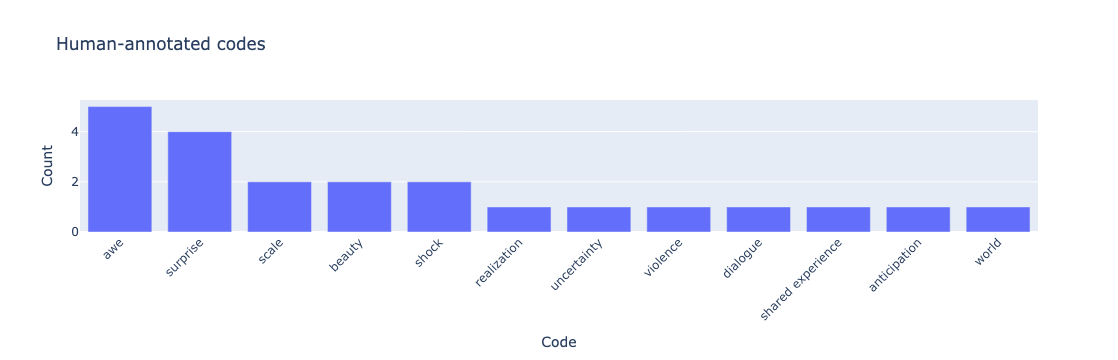

In [16]:
# @title
def get_codes_df(df):
    codes = [code for coded_text in df.coded_text for _, code in llmcode.parse_codes(coded_text)]
    code_counts = Counter(codes)
    df_codes = pd.DataFrame(list(code_counts.items()), columns=['Code', 'Count'])
    df_codes = df_codes.sort_values(by='Count', ascending=False).reset_index(drop=True)
    return df_codes

df_codes = get_codes_df(df_val)

# Create a vertical bar plot using Plotly with angled x-axis labels
fig = px.bar(df_codes, x='Code', y='Count', title='Human-annotated codes')

# Update layout to angle x-axis labels at 45 degrees
fig.update_layout(xaxis_tickangle=-45)

fig.show()

## Coding and quality metrics

In this notebook, we will be using the `code_inductively_with_code_consistency()` function from the LLMCode package. This function codes the input texts given:
* the research question, defined earlier
* the set of few-shot examples, defined earlier
* a list of *ancestors* for each text in the input data and few-shot examples, providing the thread context of the text to the model 
* a bulleted list of coding instructions, given as a string.

After coding the texts, the function attempts to correct some common errors that the LLM may make, such as correcting typos or omitting some non-coded sentences of the original text. For further analysis, it is important that the LLM preserves the exact formatting of the original texts.

The term *code consistency* in the function name refers to the function's attempt to generate consistent codes across the different texts, similarly to a human coder. The function processes the texts sequentially, to allow the reuse of codes between text instances instead of creating an entirely new set of possibly redundant codes for each text. This is done by keeping track of a list of previous codes that is added as input to each new prompt.

If you take a closer look at the code, you may notice that the function also generates a description for each code. This is in order to avoid generating duplicate codes with the same meaning. We store these descriptions at the end of this notebook alongside the coded texts, as they may be useful in further processing of the codes, by elaborating on their meaning.

Run the following cell to code the input texts with the `code_inductively_with_code_consistency()` function. This may take a few moments.

In [11]:
# @title

def code_inductively(df_input, coding_instructions):
    input_texts = df_input.text.tolist()
    input_ancestors = [get_ancestor_texts(id) for id in df_input.index]
    return llmcode.code_inductively_with_code_consistency(
        texts=input_texts,
        text_ancestors=input_ancestors,
        research_question=research_question,
        coding_instructions=coding_instructions,
        few_shot_examples=df_few_shot,
        few_shot_ancestors=few_shot_ancestors,
        gpt_model=gpt_model
    )

# Instructions that are appended to the LLM prompt
coding_instructions = f"""- Ignore text that is not insightful with regards to the research question: {research_question}."""

# Do inductive coding
coded_texts, code_descriptions = code_inductively(df_val, coding_instructions)

print("Coding complete, proceed to the next cell to see the output")

 |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.0% 
Coding complete, proceed to the next cell to see the output


Next, we evaluate the LLM's output against human-coded texts from our validation set, i.e. some instances from `coded_file` that weren't used as few-shot examples.

We print out a table that contains the LLM- and human-coded texts side by side. This table also contains two metrics to help you evaluate the model's output: [Intersection over Union (IoU, a.k.a. Jaccard Index)](https://en.wikipedia.org/wiki/Jaccard_index) and a modified [Hausdorff distance measure](https://en.wikipedia.org/wiki/Hausdorff_distance).

**IoU** calculates the overlap between LLM- and human-highlighted parts of each text, measuring how similarly the model can identify interesting parts in the text to a human coder. For the IoU score, 0 means no overlap and 1 means perfect overlap, i.e., identical human and LLM highlights. 

IoU does not tell us anything about the codes that are assigned to each highlight, for which reason we also calculate the **Hausdorff distance** between each pair of LLM- and human-coded texts. Note that the coded parts of the text may vary between annotators, which makes a highlight level evaluation of codes difficult. In order to address this issue, we compare the codes on a text level (as opposed to highlight level), by merging all the codes that are assigned to any highlight in the text. The Hausdorff distance measure calculated by the LLMCode package then utilizes code embeddings to evaluate the semantic similarity between the LLM and human-generated codes for each text.

You can choose to sort the texts by either of the two metrics. This enables you to easily spot cases where the model is doing well or underperfoming. Note that a **higher IoU is better** (higher IoU = more overlap between highlighted segments), while a **lower Hausdorff distance is better** (lower distance = codes are more similar). Be sure to also compare the LLM- and human-annotated texts yourself, as sometimes the errors may be due to inconsistencies in your own coding.

In [14]:
#-------------------------------------------------------
#User-defined parameters. You can freely edit the values

sort_by = "IoU" # @param ["IoU","Hausdorff","Input order"]

#-------------------------------------------------------------------
#Implementation. Only edit this part if you know what your are doing

html_report, df_eval = llmcode.run_coding_eval(
    llm_coded_texts=coded_texts,
    human_coded_texts=df_val.coded_text.tolist(),
    embedding_context=embedding_context,
    embedding_model=embedding_model,
    sort_by=sort_by
)

avg_iou = np.mean(df_eval["IoU"])
avg_hausdorff = np.mean(df_eval["Hausdorff"])
print(f"Average IoU: {avg_iou:.4f}")
print(f"Average Hausdorff distance: {avg_hausdorff:.4f}")

display(HTML(html_report))

Loaded embeddings from cache, hash b179f6a5bb2327e66fb357323b2a6c56
Average IoU: 0.3832
Average Hausdorff distance: 0.0683


,llm_coded_text,human_coded_text,IoU,Hausdorff
3,Likewise.,Likewise.,1.000000,0.000000
11,Except no annoyingly whiny red plants or vomiting armored cockroaches.,Except no annoyingly whiny red plants or vomiting armored cockroaches.,1.000000,0.000000
18,This 100%. I jaw hit the floor when the cavern opened. I was NOT ready for that!awe; surprise,This 100%. I jaw hit the floor when the cavern opened. I was NOT ready for that!shock; surprise; awe,1.000000,0.018913
6,"I knew going into the game that it was gonna be pretty, but seeing the vast expanse of Siofra River as I descended the elevator made my jaw hit the fucking floor.awe Easily the most beautiful area in the game.awe","I knew going into the game that it was gonna be pretty, but seeing the vast expanse of Siofra River as I descended the elevator made my jaw hit the fucking floorscale; awe. Easily the most beautiful area in the gamebeauty.",0.949153,0.063900
14,"Siofra river reveal is definitely my fave too, just due to the absolute sheer scale of exploration being laid bare before me as if to accent I still had much more to explore than I thought in the world.scale; awe","Siofra river reveal is definitely my fave too, just due to the absolute sheer scale of exploration being laid bare before me as if to accent I still had much more to explore than I thought in the worldscale; anticipation; surprise.",0.927419,0.066010
2,nothing is quite as memorable that seeing your character looking like a pin cushion for several minutes.awe; danger,nothing is quite as memorable that seeing your character looking like a pin cushionviolence for several minutes.,0.661290,0.134691
15,I never had the cartoon ‘jaw-drop’ until that moment. I was alone in my room almost drooling because of the beautiful world opening up to me!awe; immersion,I never had the cartoon ‘jaw-drop’ until that moment. I was alone in my room almost drooling because of the beautiful world opening up to me!awe; beauty; world,0.630631,0.060079
5,"“Oh Fuck, this game is even bigger than I thought”surprise and then “Oh FUCK I do no damage to these things”danger; frustration","“Oh Fuck, this game is even bigger than I thought”surprise; realization and then “Oh FUCK I do no damage to these things”",0.558824,0.084580
12,Yes! Felt like I was traveling for ages!determination Kept telling my friends about that experience. It was my first underground area and it was just so jaw droppingawe; connection,Yes! Felt like I was traveling for ages! Kept telling my friends about that experience.shared experience It was my first underground area and it was just so jaw droppingawe,0.512605,0.059159
1,Yeah me it was the first elevator down to Sofia River… I had no idea what to expect and then bam… that view of that huge purple expanse.surprise; awe That’s when I realized this game was much larger and more diverse than I had ever imaginedrealization; scale,Yeah me it was the first elevator down to Sofia River… I had no idea what to expect and then bam…uncertainty; surprise that view of that huge purple expanse. That’s when I realized this game was much larger and more diverse than I had ever imagined,0.235294,0.089820


Next, let's visualize all the LLM-generated codes and the number of times they appear. You may wish to compare these to the human-annotated code distribution above, and see how well they match. Can you find any new codes, or ones that are missing?

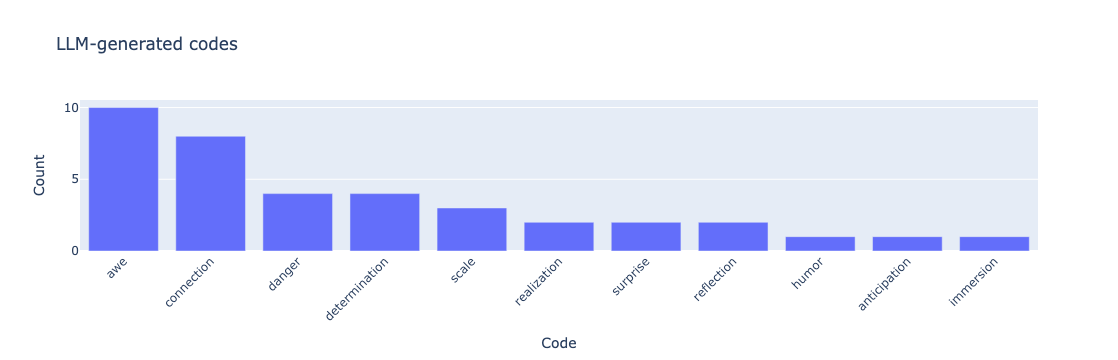

In [15]:
# @title
def plot_generated_codes(code_highlights, title):
    code_counts = [(code, len(highlights)) for code, highlights in code_highlights.items()]
    df_codes = pd.DataFrame(code_counts, columns=['Code', 'Count'])
    df_codes = df_codes.sort_values(by='Count', ascending=False).reset_index(drop=True)

    # Create a vertical bar plot using Plotly with angled x-axis labels
    fig = px.bar(df_codes, x='Code', y='Count', title=title)

    # Update layout to angle x-axis labels at 45 degrees
    fig.update_layout(xaxis_tickangle=-45)
    fig.show()

# Parse all codes and highlights in LLM output
code_highlights = llmcode.get_codes_and_highlights(coded_texts)
plot_generated_codes(code_highlights, 'LLM-generated codes')

In order to compare the human- and LLM-generated codes in more detail, let's visualize the codes with the help of _word embeddings_, which capture the meaning of words and can therefore be used to explore code similarities. We will use OpenAI's embedding models for this. Word embeddings are typically very high-dimensional vectors, so we will reduce the dimensionality of the vectors to two in order to plot them onto a two-dimensional plane.

We create an interactive visualization of the code embeddings using Plotly, so that you can hover over the plot to reveal the code name and an example of an associated highlight from the texts. The size of each marker corresponds to the total number of highlights for that code in the texts. The visualization contains markers for three kinds of codes:
* LLM code (new): A code entirely generated by the LLM.
* LLM code (few-shot): A code generated by the LLM that was included in the few-shot examples given to it.
* Human code: A code in the human-annotated input texts, for comparison.

Note that there is likely a lot of overlap between the markers as both LLM- and human-annotated codes are plotted, so be sure to hover your mouse over the plot to view details of any overlapping markers.

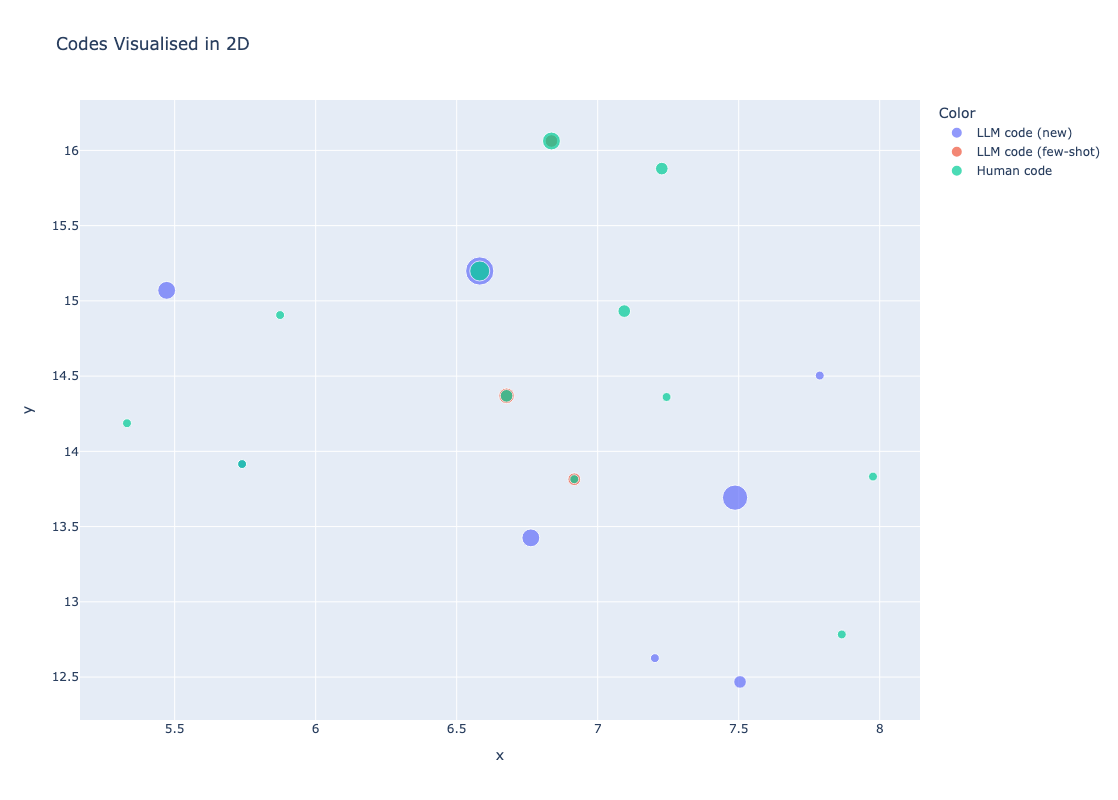

In [18]:
# @title
def prepare_code_vis_df(code_highlights, human_code_highlights, few_shot_codes, embedding_context, embedding_model):
    # Find code embeddings for all codes
    all_codes = set(code_highlights.keys()).union(set(human_code_highlights.keys()))
    df_em = llmcode.get_2d_code_embeddings(list(all_codes), embedding_context, embedding_model)

    # Create DataFrame of LLM-generated codes
    df_llm = pd.DataFrame([(c,) for c in code_highlights.keys()], columns=["code"])
    df_llm["code_count"] = df_llm["code"].apply(lambda code: len(code_highlights[code]))
    df_llm["example"] = df_llm["code"].apply(lambda code: code_highlights[code][0])
    df_llm["group"] = df_llm.code.apply(lambda code: "LLM code (few-shot)" if code in few_shot_codes else "LLM code (new)")

    # Create DataFrame of human-generated codes
    df_human = pd.DataFrame([(c,) for c in human_code_highlights.keys()], columns=["code"])
    df_human["code_count"] = df_human["code"].apply(lambda code: len(human_code_highlights[code]))
    df_human["example"] = df_human["code"].apply(lambda code: human_code_highlights[code][0])
    df_human["group"] = "Human code"

    # Concatenate code DataFrames and merge with embeddings
    df_em_codes = pd.concat([df_llm, df_human])
    df_em_codes = df_em_codes.merge(df_em, on="code", validate="many_to_one")
    return df_em_codes

def visualise_2d_embeddings(df_em):
    # Prepare labels for visualisation
    hover_texts = []
    colors = []  # List to store color categories
    for _, row in df_em.iterrows():
        text = f"{row.code} ({row.code_count})</br></br>"

        # Add an example of a code highlight
        text += '"' + "</br>".join(textwrap.wrap(row.example, width=60)) + '"'

        hover_texts.append(text)

        # Determine color category based on group
        colors.append(row.group)

    df_vis = pd.DataFrame()
    df_vis["Hover"] = hover_texts
    df_vis["Size"] = [c / df_em["code_count"].max() for c in df_em["code_count"]]
    df_vis["x"] = df_em["code_2d_0"]
    df_vis["y"] = df_em["code_2d_1"]
    df_vis["Color"] = colors

    # Plot the codes in 2D
    fig = px.scatter(df_vis,
                     width=1000, height=800,
                     x="x",
                     y="y",
                     size="Size",
                     color="Color",  # Set color categories
                     hover_name="Hover",
                     title="Codes Visualised in 2D")


    fig.show()

human_code_highlights = llmcode.get_codes_and_highlights(df_val.coded_text)
df_em = prepare_code_vis_df(
    code_highlights,
    human_code_highlights,
    few_shot_codes,
    embedding_context,
    embedding_model
)
visualise_2d_embeddings(df_em)

## Prompt iteration

Now that we've gotten a handle on how coding with LLMCode works, as well as the metrics by which we can evaluate the coding quality, let's see if we can increase the performance of the model by iterating on the coding instructions given to the model as part of the prompt. For reflexive coding, the coder's own understanding of the topic and the data is important in shaping the findings. By tuning the instructions, you can help the model understand how you personally coded the data.  

First, run the following cell that prepares a function for both coding and the subsequent evaluation of the coded data, allowing us to neatly test the entire pipeline with different instructions.

In [19]:
# @title

def code_and_eval(
    df_input,
    coding_instructions,
    sort_by="IoU",
):
    # Perform inductive coding
    coded_texts, _ = code_inductively(df_input, coding_instructions)
    
    # Run eval
    html_report, df_eval = llmcode.run_coding_eval(
        llm_coded_texts=coded_texts,
        human_coded_texts=df_input.coded_text.tolist(),
        embedding_context=embedding_context,
        embedding_model=embedding_model,
        sort_by=sort_by
    )

    # Print averages
    avg_iou = np.mean(df_eval["IoU"])
    avg_hausdorff = np.mean(df_eval["Hausdorff"])
    print(f"Average IoU: {avg_iou:.4f}")
    print(f"Average Hausdorff distance: {avg_hausdorff:.4f}")

    # Visualise results
    code_highlights = llmcode.get_codes_and_highlights(coded_texts)
    human_code_highlights = llmcode.get_codes_and_highlights(df_input.coded_text)
    df_em = prepare_code_vis_df(
        code_highlights,
        human_code_highlights,
        few_shot_codes,
        embedding_context,
        embedding_model
    )
    visualise_2d_embeddings(df_em)

    # Print table
    display(HTML(html_report))

print("Instruction iteration function ready, proceed")

Instruction iteration function ready, proceed


The following cell runs the coding and evaluation with a `coding_instructions` string variable that you can modify to your liking. The instructions defined here are appended to the LLM prompt, to help it understand how you would like the texts to be coded. Output format instructions and the few-shot examples are already added to the prompt automatically by LLMCode, so these should not be included in `coding_instructions`.

The variable is initialised with the same instructions given to the model in the previous section: a single item instructing the model to focus on the defined research question. Based on the evaluations you ran in the previous section, try to improve upon these instructions by adding new lines and running the cell to see if you can improve the model's performance. Place each new instruction on its own line beginning with a dash.

Below, we have provided three identical cells so you may iterate on the instructions by adding lines to the `coding_instructions` variable and running the coding multiple times until you're happy with the output. This way, we store a trace of the results you got with the previous instructions. Before running each cell, copy the instructions from the previous cell and add one or more additional lines.

 |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.0% 
 |----------------------------------------------------------------------------------------------------| 0.0% 
Average IoU: 0.4292
Average Hausdorff distance: 0.0713
 |----------------------------------------------------------------------------------------------------| 0.0% 


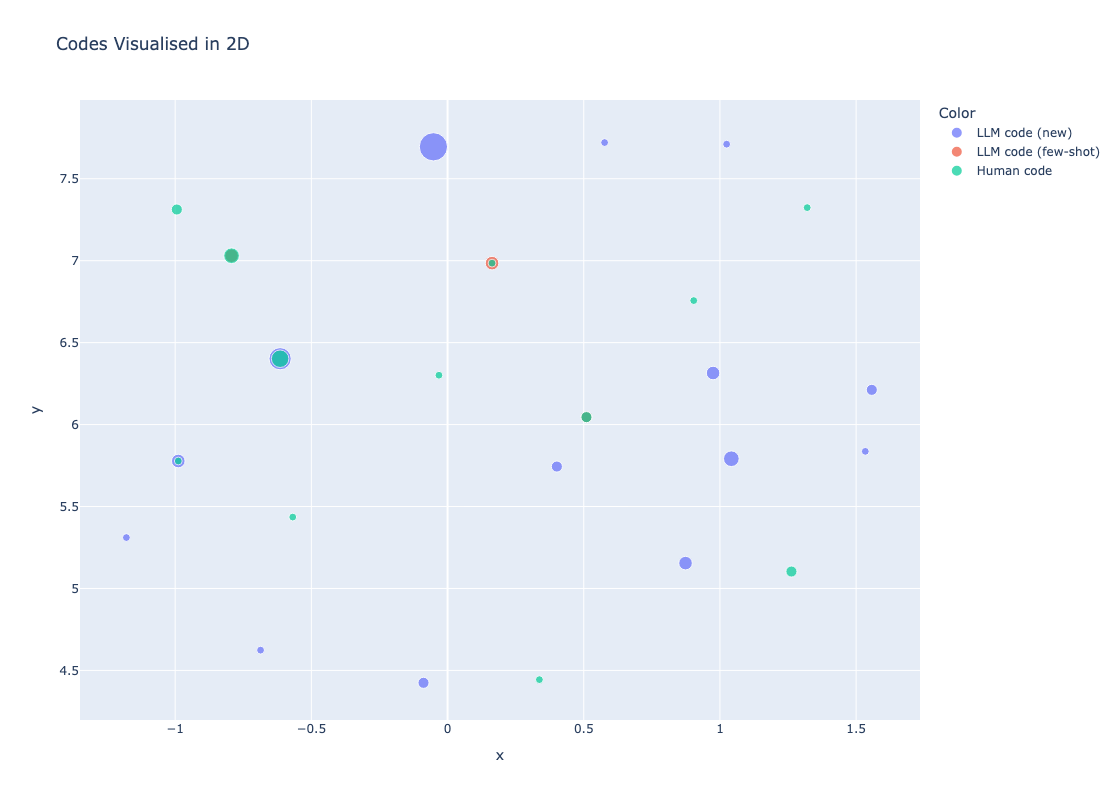

,llm_coded_text,human_coded_text,IoU,Hausdorff
3,Likewise.,Likewise.,1.000000,0.000000
18,This 100%. I jaw hit the floor when the cavern opened.awe; surprise I was NOT ready for that!impact; surprise,This 100%. I jaw hit the floor when the cavern opened. I was NOT ready for that!shock; surprise; awe,1.000000,0.032850
9,"""But hell, I'm not turning back""determination; perseverance. Oh, yeah.","""But hell, I'm not turning back"". Oh, yeah.",1.000000,0.000000
7,Best dialogue in the gameimpact,Best dialogue in the gamedialogue,1.000000,0.136444
15,I never had the cartoon ‘jaw-drop’ until that moment. I was alone in my room almost drooling because of the beautiful world opening up to me!awe; immersion; emotion,I never had the cartoon ‘jaw-drop’ until that moment. I was alone in my room almost drooling because of the beautiful world opening up to me!awe; beauty; world,0.990991,0.068025
14,"Siofra river reveal is definitely my fave too, just due to the absolute sheer scale of exploration being laid bare before mescale; awe as if to accent I still had much more to explore than I thought in the world.anticipation","Siofra river reveal is definitely my fave too, just due to the absolute sheer scale of exploration being laid bare before me as if to accent I still had much more to explore than I thought in the worldscale; anticipation; surprise.",0.973913,0.037599
6,"I knew going into the game that it was gonna be pretty, but seeing the vast expanse of Siofra River as I descended the elevator made my jaw hit the fucking floor.awe; visual Easily the most beautiful area in the game.impact; visual","I knew going into the game that it was gonna be pretty, but seeing the vast expanse of Siofra River as I descended the elevator made my jaw hit the fucking floorscale; awe. Easily the most beautiful area in the gamebeauty.",0.949153,0.073606
2,nothing is quite as memorable that seeing your character looking like a pin cushion for several minutes.visual; impact,nothing is quite as memorable that seeing your character looking like a pin cushionviolence for several minutes.,0.661290,0.143573
12,Yes! Felt like I was traveling for ages!anticipation Kept telling my friends about that experience. It was my first underground area and it was just so jaw droppingawe; connection,Yes! Felt like I was traveling for ages! Kept telling my friends about that experience.shared experience It was my first underground area and it was just so jaw droppingawe,0.512605,0.053701
13,This. It was 4 am and I'd been playing for 10 hours straight no breaks except to eat and use the restroom and even eating I would do at my PC (I was excited okay) and I remember stumbling across this and my mouth just. Dropped. I was so in aweawe I just sat at my desk for 5 minutes before even going back to the game.impact I told myself I'm getting too excited and this game is too good and I'm too delirious to say this but Elden Ring is the best game I've ever played.impact; realization I told myself to save that opinion for the morning when I have some rest and can think clearly. The opinion stayedreflection,This. It was 4 am and I'd been playing for 10 hours straight no breaks except to eat and use the restroom and even eating I would do at my PC (I was excited okay) and I remember stumbling across this and my mouth just. Dropped. I was so in awe I just sat at my desk for 5 minutes before even going back to the game.awe; shock I told myself I'm getting too excited and this game is too good and I'm too delirious to say this but Elden Ring is the best game I've ever played. I told myself to save that opinion for the morning when I have some rest and can think clearly. The opinion stayed,0.261682,0.071456


In [20]:
# Add more instructions, based on the evaluation results in the previous section
coding_instructions = f"""
- Ignore text that is not insightful with regards to the research question: {research_question}.
- Emphasise codes about emotions.
"""

# Run coding
code_and_eval(df_val, coding_instructions)

In [ ]:
# Copy the instruction from the previous cell and add even more instructions, based on the evaluation results in the previous cell
coding_instructions = # TODO: Copy and improve code instructions from previous cell

# Run coding
code_and_eval(df_val, coding_instructions)

In [ ]:
# Copy the instruction from the previous cell and add even more instructions, based on the evaluation results in the previous cell
coding_instructions = # TODO: Copy and improve code instructions from previous cell

# Run coding
code_and_eval(df_val, coding_instructions)

## Validation and test data

In all AI and Machine Learning, a common danger is to [overfit](https://en.wikipedia.org/wiki/Overfitting) one's model or approach to some data, making it generalize poorly to new data.

**The more you iterate on your prompt instructions and examples, the more you are in danger of overfitting.**

This is why it is a standard practice to split one's data into [three distinct parts](https://en.wikipedia.org/wiki/Training,_validation,_and_test_data_sets):

1. Training data: This is used to train a model. Whilst we're not actually training the LLM here, this is analogous to the few-shot examples we chose for the prompts since they are data for which the ground truth (i.e. the human codes) is shown to the model.

2. Validation data: This is typically used to search for the best possible [hyperparameters](https://en.wikipedia.org/wiki/Hyperparameter_(machine_learning) such as when to stop training or how many layers to use in a neural network model.

3. Test data: This is used to test the performance of the final model after the hyperparameter tuning. *Separating test and validation data avoids overly optimistic test results caused by overfitting the hyperparameters to the validation data*.

The prompt instructions, which we tuned in this notebook, can be considered as a hyperparameter. Therefore, **one should ideally iterate/optimize the prompt with validation data and when done, verify the performance with a separate set of test data**. This is especially important if your human-defined reference dataset is small.

**For academic research, we recommend using at least 100 texts for both the validation and test data**, i.e., the data file should have at least 200 texts with human-annotated ground truth highlights, as the first 100 would be used for validation and next 100 for testing.

**For industry research**, the designer or researcher should use their own judgement - how crucial is it to be able to measure the performance accurately?

### How to report LLM use in qualitative research?

There does not currently exist an established best practice for reporting LLM-based qualitative analysis tool use, but if you use the LLM-based highlighting, you could report at least the full prompt with examples, the number of validation and test data texts, the validation and test data IoUs, and a table with examples of the worst and best case LLM performance so that the reader can judge themselves if the LLM performance is acceptable.

### Evaluate the final prompt on the test data

You may recall how we earlier divided the data in `coded_file` into validation and test sets. So far, we have only used the validation data. Once you're done iterating on your `coding_instructions`, run the code below to evaluate the model using the test data. This will provide a final reading of the model's performance. Note: this will re-use the final instructions defined in the above section.

Inspect the results. Is the LLM performance different than for the validation data? Can you spot any further human annotation errors or inconsistencies that should perhaps be corrected?

 |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.0% 
 |----------------------------------------------------------------------------------------------------| 0.0% 
Average IoU: 0.4306
Average Hausdorff distance: 0.0733
 |----------------------------------------------------------------------------------------------------| 0.0% 


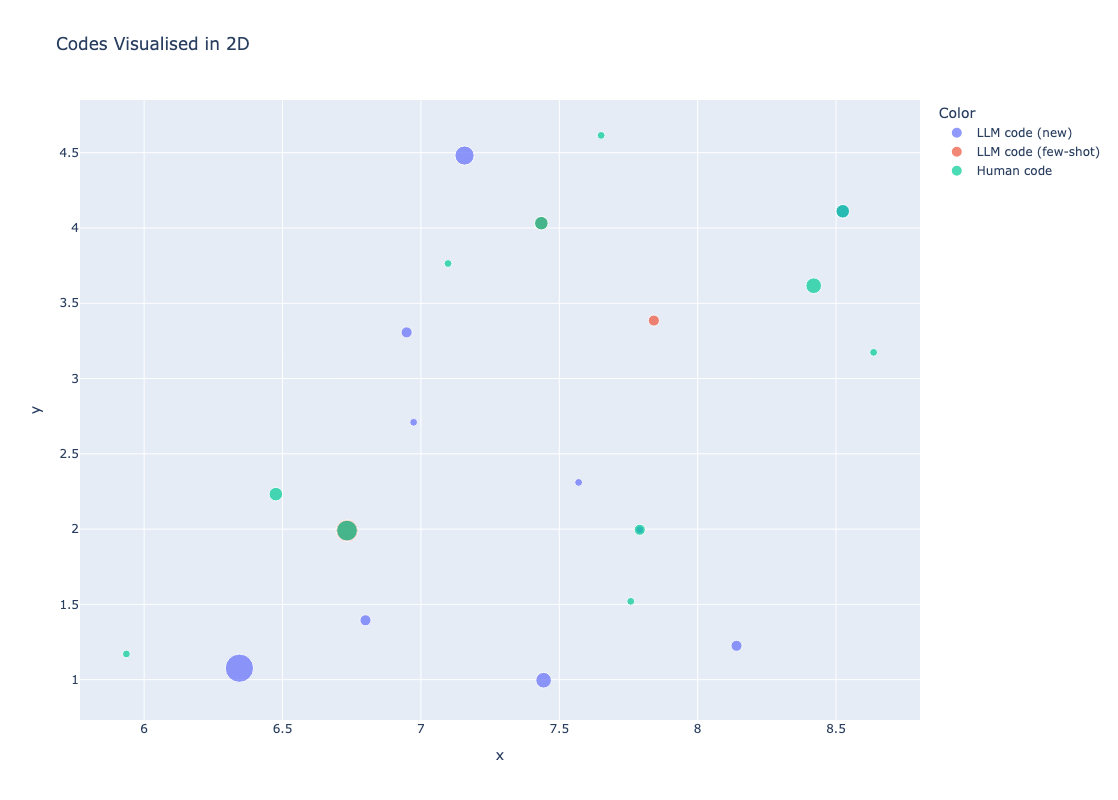

,llm_coded_text,human_coded_text,IoU,Hausdorff
1,Exactly what I thought when I went down there.,Exactly what I thought when I went down there.,1.000000,0.000000
6,"What is your most unforgettable moment in Elden Ring, Tarnished? Share your cherished memory.","What is your most unforgettable moment in Elden Ring, Tarnished? Share your cherished memory.",1.000000,0.000000
10,Well said,Well said,1.000000,0.000000
2,"The first time I went down the elevator to Nokron honestly. Underwhelming compared to other opinions maybe, but the reveal of that huge expanse was beautiful and got me excited for everything the game had in store for meemotion; importance; excitement","The first time I went down the elevator to Nokron honestly. Underwhelming compared to other opinions maybe, but the reveal of that huge expanse was beautifulsurprise; beauty and got me excited for everything the game had in store for meanticipation",0.965909,0.111074
11,"""Oh I'm not supposed to be here yet"" surprise","""Oh I'm not supposed to be here yet""surprise",0.923077,0.106706
9,"Ooooh that was a jaw dropping moment for me!! I was expecting a small underground dungeon, and then my eyes beheld this wide expanse.surprise; emotion A whole region unto itself. Incredible game designimportance; beauty","Ooooh that was a jaw dropping moment for meawe!! I was expecting a small underground dungeon, and then my eyes beheld this wide expanse.surprise; scale A whole region unto itself. Incredible game designdesign",0.790210,0.084347
3,"This was easily one of the most memorable moments in the game for me. I got on the elevator and started to read an item description. The elevator was still going when I finished reading and I thought ""damn, this is a long elevator"" and the longer it took the more excited I got.emotion; excitement Siofra River did not disappoint. That was also when I realized the world was gonna be way bigger than I expected and I had no idea how big it was.importance; realization","This was easily one of the most memorable moments in the game for me. I got on the elevator and started to read an item description. The elevator was still going when I finished reading and I thought ""damn, this is a long elevator"" and the longer it took the more excited I gotanticipation. Siofra River did not disappoint. That was also when I realized the world was gonna be way bigger than I expectedsurprise; scale and I had no idea how big it wasuncertainty.",0.587912,0.111031
4,"Came here to say this. I don’t usually gasp audibly alone in my guest room at 4am, but when I do, it’s because I saw Nokron for the first time.emotion; surprise Never before have I seen something so breathtakingly beautiful in a video game.emotion; beauty","Came here to say this. I don’t usually gasp audiblyshock alone in my guest room at 4am, but when I do, it’s because I saw Nokron for the first time. Never before have I seen something so breathtakingly beautiful in a video game.beauty; awe",0.566879,0.069429
16,"That one got me too. I just figured upon the elevator in the woods and decided to take it down, because I was getting hunted by a bunch of bears.frustration I was pretty shocked - it's not what I expected to find down there.surprise Maybe a dungeon or something.expectation I had remained pretty spoiler free, so I wasn't even aware of the existence of Ansel and Siofra rivers, let alone the fact that they'd be these massive underground areas that there's a special button for on your map.realization; scale; surprise","That one got me too. I just figured upon the elevator in the woods and decided to take it down, because I was getting hunted by a bunch of bears. I was pretty shocked - it's not what I expected to find down there.shock; surprise Maybe a dungeon or something. I had remained pretty spoiler free, so I wasn't even aware of the existence of Ansel and Siofra rivers, let alone the fact that they'd be these massive underground areas that there's a special button for on your mapsurprise;

In [21]:
# @title

# Run coding and eval on test data
code_and_eval(df_test, coding_instructions)

# Coding all of the data

Now that we've tuned the coding instructions to our liking and ran the final evaluation on the test data, it is time for us to finally code the entire dataset, including texts in `uncoded_file` that weren't annotated by a human.

When dealing with large datasets, it is wise to define a ceiling for the number of texts that are coded, as each additional text incurs a small API cost. You may edit `max_number_of_texts` based on how many texts you wish to code. If your files contain more texts, the system will code the first `max_number_of_texts` from the two files.

In [23]:
max_number_of_texts = 100 # @param {type:"integer"}

# Do inductive coding on all data, capping to max_number_of_texts
df_final = df_all.head(max_number_of_texts)
coded_texts, code_descriptions = code_inductively(df_final, coding_instructions)

def print_coded_texts(coded_texts, sample_n=None):
    if sample_n:
        coded_texts = random.sample(coded_texts, sample_n)
    for coded_text in coded_texts:
        display(Markdown(coded_text))
        display(Markdown("-----"))

print("Coding complete, output:\n")
print_coded_texts(coded_texts)

 |████------------------------------------------------------------------------------------------------| 4.0% WARNING: A total of 1 LLM outputs were discarded because of errors

 |███████████████████████████████████████████████████████████████████████████████████████-------------| 87.0% WARNING: A total of 1 LLM outputs were discarded because of errors

 |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.0% 
Coding complete, output:



What is your most unforgettable moment in Elden Ring, Tarnished? Share your cherished memory.

-----

The first time I went down the elevator to Nokron honestly. Underwhelming compared to other opinions maybe, but **the reveal of that huge expanse was beautiful and got me excited for everything the game had in store for me**<sup>awe; excitement</sup>.

-----

MY GOD this was incredible. **First time I went down to the Siofra River I was completely shocked at how massive the scale seemed to be**<sup>awe; scale</sup>

-----

<IPython.core.display.Markdown object>

-----

nothing is quite as memorable **that seeing your character looking like a pin cushion for several minutes.**<sup>intensity; impact</sup>

-----

I **took an arrow to every oriface.**<sup>impact; intensity</sup>

-----

I used to be an adventurer like you. **Then I took an arrow in the… look, adventuring is dangerous ok, can we leave it at that?**<sup>humor; danger</sup>

-----

A six foot spectral arrow embedded in your chest fired from an enemy you didn't even know existed **humbles you real quick**<sup>impact; intensity</sup>

-----

Well said

-----

I’ve never dived for cover so fast and then **caught another arrow to the face from some other direction entirely**<sup>danger; intensity</sup>.  **That place nearly gave me ptsd**<sup>impact; fear</sup>.  **The fear when I had to go back to that zone in NG+ was real**<sup>fear; intensity</sup>.

-----

"Oh **I'm not supposed to be here yet**" <sup>surprise</sup>

-----

"But hell, I'm not turning back". **Oh, yeah.**<sup>determination; perseverance</sup>

-----

I think I said out loud “**oh shits it’s a Blackreach**”<sup>surprise; excitement</sup>

-----

Exactly what I thought when I went down there.

-----

Likewise.

-----

Fourthed. Until I went back there at a much higher level and **nothing could really hurt me. Kind of dispelled the earlier mythos I had in my mind which was a bit sad.**<sup>empowerment; nostalgia</sup>

-----

Underrated comment

-----

Except **no annoyingly whiny red plants or vomiting armored cockroaches**<sup>enjoyment; frustration</sup>.

-----

This is one of my favoirites as well. **I felt I found something I was not suposed to find this early in the game.**<sup>surprise</sup> And it was great, despite the **deadly arrows**<sup>danger</sup>.

-----

Yeah, **thats been the biggest deal for me too thus far**<sup>intensity; frustration</sup> and **those snipers were absurd**<sup>frustration; danger</sup>.

-----

I lost my shit. 

"Oh whats this little house"

"Oh cool a lift"

**"whaaaaaaaaaaaaatt"**<sup>surprise; excitement</sup>

-----

“Huh, this elevator is taking a *whiiiiiiile*” **<sup>anticipation; impatience</sup>**

-----

Whenever I used that elevator, **I would get up, grab some water, and when I came back, the elevator was still going.**<sup>anticipation; waiting</sup>

-----

Agreed, also **the map expanding slowly, every new area was like “wtf there’s more”**<sup>scale; surprise; excitement</sup>

-----

i felt like for a while, **whenever we get a new playable area, the map does it in a way to make me feel like the map just doubled its size.**<sup>scale; enjoyment</sup>

-----

I knew going into the game that it was gonna be pretty, but **seeing the vast expanse of Siofra River as I descended the elevator made my jaw hit the fucking floor.**<sup>awe; impact</sup> **Easily the most beautiful area in the game.**<sup>beauty; impact</sup>

-----

Oh yeah, going down the Siofra River Well was easily my favorite moment of the game. Followed by getting the map for the underground and **realizing there was going to be a whole lot more of it**<sup>realization; discovery; exploration</sup>.

-----

Ooooh that was a **jaw dropping moment for me!!**<sup>awe</sup> I was expecting a small underground dungeon, and then **my eyes beheld this wide expanse. A whole region unto itself.**<sup>surprise; awe</sup> **Incredible game design**<sup>impact</sup>.

-----

This was easily one of the most memorable moments in the game for me. **I got on the elevator and started to read an item description. The elevator was still going when I finished reading and I thought "damn, this is a long elevator" and the longer it took the more excited I got.**<sup>anticipation; excitement</sup> **Siofra River did not disappoint. That was also when I realized the world was gonna be way bigger than I expected and I had no idea how big it was.**<sup>realization; exploration</sup>

-----

Everything is so well timed. **Takes \*just\* long enough that you get anxious and start to see things**<sup>timing; anxiety</sup>

-----

Came here to say this. **I don’t usually gasp audibly alone in my guest room at 4am, but when I do, it’s because I saw Nokron for the first time.**<sup>anticipation; awe</sup> **Never before have I seen something so breathtakingly beautiful in a video game.**<sup>beauty; impact</sup>

-----

This 100%. **I jaw hit the floor when the cavern opened. I was NOT ready for that!**<sup>awe; surprise</sup>

-----

I felt so dumb. I went to that forest, even right to the minor erdtree following the path from the church, and completely missed it. I went through a lot of Caelid before my friend told me I missed it. **I feel like I got a lot of other “wow” moments before I got to that one, so I didn’t get the surprise of scale as much.**<sup>surprise; disappointment</sup>

-----

Same! I came here to say this. **The first time going into Nokron was one of the coolest experiences I’ve had as a gamer.**<sup>enjoyment; impact</sup>

-----

This is honestly **one of the best location reveals for me in any game.**<sup>impact; surprise</sup> Same for the capital.

-----

“Oh Fuck, this game is even bigger than I thought”<sup>surprise</sup> and then “Oh FUCK I do no damage to these things”<sup>frustration</sup>

-----

This. **It was 4 am and I'd been playing for 10 hours straight no breaks except to eat and use the restroom and even eating I would do at my PC (I was excited okay)**<sup>intensity; excitement</sup> **and I remember stumbling across this and my mouth just. Dropped. I was so in awe**<sup>awe</sup> **I just sat at my desk for 5 minutes before even going back to the game. I told myself I'm getting too excited and this game is too good and I'm too delirious to say this but Elden Ring is the best game I've ever played.**<sup>realization; enjoyment</sup> **I told myself to save that opinion for the morning when I have some rest and can think clearly. The opinion stayed**<sup>determination</sup>.

-----

I agree, **reminded me of the underground eco system on Skyrim where the snow elves recluses to**<sup>nostalgia; connection</sup>.

-----

Siofra river reveal is definitely my fave too, **just due to the absolute sheer scale of exploration being laid bare before me as if to accent I still had much more to explore than I thought in the world.**<sup>awe; exploration; scale</sup>

-----

That one got me too.  **I just figured upon the elevator in the woods and decided to take it down, because I was getting hunted by a bunch of bears.**<sup>exploration; surprise</sup>  **I was pretty shocked - it's not what I expected to find down there.**<sup>surprise; impact</sup>  **Maybe a dungeon or something.**<sup>anticipation</sup>  **I had remained pretty spoiler free, so I wasn't even aware of the existence of Ansel and Siofra rivers, let alone the fact that they'd be these massive underground areas that there's a special button for on your map.**<sup>discovery; scale</sup>

-----

Yeah me it was the first elevator down to Sofia River… **I had no idea what to expect and then bam… that view of that huge purple expanse.**<sup>surprise; awe</sup> **That’s when I realized this game was much larger and more diverse than I had ever imagined**<sup>realization; awe</sup>.

-----

First time I went down the elevator I was **baffled by all its majesty**<sup>awe</sup>. I got to the ground floor, made my way to the first group of Clay men, took one swing at them with my bloodhound fang that dealt very little damage and **nope'd the hell on outta there**<sup>fear; intensity</sup>.

-----

Sioftra river you mean? **Nokron was accessible after you killed Radhan you hopped down the floating boulders. But I know what you mean. Had same feeling**<sup>connection; determination</sup>

-----

Dude i was **shitting my pants down that lift to Nokron.**<sup>fear</sup> **I clearly remember just saying “holy fuuuuck” and taking it all in.**<sup>awe</sup>

-----

I never had the cartoon ‘jaw-drop’ until that moment. **I was alone in my room almost drooling because of the beautiful world opening up to me!**<sup>awe; beauty</sup>

-----

>	The first time I went down the elevator to Nokron honestly. 

**The moment I saw that elevator my first thought was “I’m going to end up in Blackreach.”**<sup>anticipation; fear</sup>

-----

Yes! **Felt like I was traveling for ages!**<sup>anticipation; intensity</sup> **Kept telling my friends about that experience. It was my first underground area and it was just so jaw dropping**<sup>awe; excitement</sup>

-----

Yeah, this is hands down **one of my top soulsborneringiro moments!**<sup>connection; enjoyment</sup>

-----

Graceless Tarnished. 

What is thy business with these thrones?

Ahhhh….

**Godrick the Golden.**<sup>impact</sup> 

**The twin prodigies, Miquella and Malenia.**<sup>impact</sup> 

**General Radahn.**<sup>impact</sup> *Praetor Rykard.* **Lunar princess Ranni.**<sup>impact</sup> 

**Willful traitors, all!**<sup>impact</sup> 

Thy kind are all of a piece. Pillagers, emboldened by the flame of ambition!

**Have it writ upon thy meagre grave. Felled, by King Morgott! Last of all kings.**<sup>impact; intensity</sup>

-----

Best dialogue in the game

-----

Agreed. **Morgott is gonna live rent free in my head forever.**<sup>connection; impact</sup>

-----

The Golden Order did not deserve **Morgott**<sup>connection; disappointment</sup>.

-----

"**What is the business with these thrones?**" <sup>connection</sup>

"**Dad, we're just playing musical chairs**" <sup>humor</sup>

"**Willful traitors, all! Thy kind are all of a piece. Pillagers, emboldened by the flame of ambition! Have it writ upon thy meagre grave. Felled, by King Chairgott! Last of all kings.**" <sup>connection; humor</sup>

"**Not again..**" <sup>frustration</sup>

-----

I'll raise you a **NOW WE CAN DEVOUR THE GODS TOGETHA!**<sup>excitement; connection</sup>

-----

Idk **ryards is pretty up there**<sup>impact</sup>

-----

I think you mean **"Thank you very much. Mum was always the only one who said I was beautiful. And now, my dear lord let me hear her voice. Please, if I may dream, just once... Do you feel the same way my mum did m'lord? Do you think I'm beautiful, despite these looks?"**<sup>connection; vulnerability</sup>

-----

I would have to argue **Morgott is a core memory for me, not because of his character or anything like that but it was my first time doing shrooms and they kicked in right as I entered the boss fight, he walked up to me looking like a clay animation and then promptly destroyed me in a flurry of cartwheels and holy daggers.**<sup>connection; impact; surprise; excitement</sup>

-----

>Have it writ upon thy meagre grave. Felled, by King Morgott! Last of all kings.

**Savage af**<sup>impact; intensity</sup>

-----

Morgott is for sure **my fav Demi god**<sup>connection</sup> **fav demi god fight is Radahn or Rykard though.**<sup>connection; intensity</sup>

-----

My fav fight is by far **Malenia or Maliketh (not technically a demigod but still)**<sup>connection; intensity</sup>. **Morgott might be my favorite demigod too. Favorite character overall is obviously Millicent**<sup>connection; enjoyment</sup>.

-----

love the emphasis on **praetor rykard. morgott added a little something to that one. he has a personal vendetta w rykard**<sup>connection; intensity</sup>

-----

Probably because **he and rykard fought the “most appalling battle in the entirety of the shattering”**<sup>intensity; impact</sup>

-----

honestly. **mt. gelmir is just completely littered with bodies.**<sup>scale; impact</sup> **it probably smells so fucking terrible lol.**<sup>intensity; humor</sup>

-----

Oh yeah. **It’s the only area of the game I genuinely hate too.**<sup>frustration</sup> **Sucks because there’s a ton of content in Mt. Gelmir**<sup>disappointment</sup>.

-----

If you beat margit that means **you learned how to git gud**<sup>empowerment; determination</sup>. If you beat margott that means **you got gud**<sup>empowerment; determination</sup>.

-----

Ok, you ***points at Malenia, Ranni, Radahn, Miquella and Godrick***<sup>connection; disappointment</sup> you are traitors, you ***points at Rykard***<sup>disappointment</sup> are even worse, but you ***points at Mohg***<sup>connection</sup> you are fine.

-----

When my friend and I **beat the Elden Beast together**<sup>achievement</sup>. We stood back to back with the lean against wall pose and he said “$120 well spent” **cuz he bought me the game when I couldn’t afford it**<sup>gratitude; connection</sup>. **Truly an Elden Lord**<sup>empowerment</sup>.

-----

Not only is this an awesome memory, but **you have yourself one helluva friend.**<sup>gratitude; connection</sup> Cheers to them!

-----

He was the one who got me into FromSoft in the first place. **I came over and he let me play DS3.**<sup>connection</sup> **I remember when I asked for help on Gundyr and he just kind of knowingly smiled and said “nah, you gotta do it yourself”**<sup>empowerment; determination</sup>

-----

>**“nah, you gotta do it yourself”**<sup>determination; empowerment</sup>

He an OG, triple OG, dark souls vet fan.

-----

Exactly. **He knew that I had to do it alone, otherwise I’d never succeed further into the game**<sup>perseverance; realization</sup>

-----

My mom struggles to learn this lesson. **My dad keeps bailing her out, lol**<sup>connection</sup>

-----

He needs to let her suffer, **it’s part of the experience**<sup>vulnerability; empowerment</sup>

-----

That fight unfortunately **filtered my wife out**<sup>frustration</sup>. She's an Animal Crossing, JRPG, strategy gamer. I wanted her to experience the rest of the game, so I offered to beat him for her and she declined every time. She tried many, many, *MANY* times to beat him but was unable. I tried to teach her how to block and dodge but it was just something of which she couldn't get the hang.

She stopped and said, **"I'm just gonna pretend my guy isn't the main character"**<sup>resignation; identity</sup> and hasn't attempted since.

-----

That's kinda depressing ngl. **You should beat the game on her account for her and let her take the final hit at the end.**<sup>empowerment</sup> **Send her out with a bang, ya know?**<sup>anticipation; connection</sup>

-----

That's a surprisingly wholesome way of handling it. **I've seen a lot of people try to take a shit on FromSoft games because *they* couldn't beat the first boss.**<sup>frustration</sup> **But just deciding they must not be the main character sounds like a pretty down to earth way of thinking.**<sup>perspective</sup> **I'm gonna guess she doesn't let herself get stressed out over stuff she can't control in real life?**<sup>realization</sup>

-----

Oh man this reminds me of when my little sister first picked up ds3. **It was her first time playing a from game.**<sup>surprise</sup> **It was about twenty minutes in when she also ask for help with gundyr.**<sup>anticipation</sup> I told her to circle around him and be patient. **Her response really surprised me. She said "no, I know that. I mean when he transforms."**<sup>realization; surprise</sup> And I just stared at her completely blankly because **I realized I never really learned phase two.**<sup>realization</sup> I always just threw myself at him till I got lucky. After a while I just go "do you have fire bombs? He's weak to fire." **She proceeded to destroy gundyr.**<sup>achievement; empowerment</sup> **Five hours later she had beaten the abyss watchers on her second try by summoning gotthard.**<sup>achievement; empowerment</sup> **Really made me realize how much easier it is to learn things when you're young.**<sup>realization</sup>

-----

My son has watched me play intermittently. **I beat the last two bosses with him watching and it felt like I was a true lord.**<sup>achievement; empowerment</sup> **He was more hyped than me. It was awesome.**<sup>excitement; connection</sup>

-----

That's so cute and wholesome, **bonding over videogames is the best!**<sup>connection; enjoyment</sup>

-----

Every new years eve, **I'd take the kids out and let them pick a videogame for family game night.**<sup>connection; enjoyment</sup> **People made fun of me for it! Moms don't play videogames, grow up, they're for kids, blah blah blah.**<sup>vulnerability</sup> **We had a BLAST playing all kinds of different games- they're 17-21 now and still ask if we're getting a game to play nye for when they get home.**<sup>nostalgia; connection</sup> **The answer is always "hell yes!"**<sup>empowerment; enjoyment</sup>

-----

This is a **dope family ritual**<sup>connection; enjoyment</sup>

-----

Chad Mom.

*Insert picture of comment here*

Chad Mom.

-----

I woke my son up to let him watch me beat the Elden Beast. **He said thanks too.**<sup>gratitude; connection</sup>

-----

His generosity **befits a crown.**<sup>gratitude</sup>

-----

Get your friend a maiden<sup>humor</sup>.

-----

**Or be the maiden yourself**<sup>connection; identity</sup>

-----

<IPython.core.display.Markdown object>

-----

My best-friend and I bought it together back in early March. **We were roommates at the time. Our 12-year friendship ended before either of us beat it a month later.**<sup>connection; vulnerability</sup> **We don’t talk anymore.**<sup>vulnerability</sup> Cheers to you and your friend m8 ❤️ game on 🎮

-----

My friends chipped in to get a buddy to play and **twinked him out, well worth, this game is sh much better with the boys**<sup>connection; enjoyment</sup>

-----

I’m not gonna lie, **this was heart warming as fuck**<sup>gratitude; enjoyment</sup>

-----

Your friend is cool as fuck

-----

What a cool guy!

-----

Probably **storming radahn with a small army and getting absolute fucking powerbombed in phase 2**<sup>intensity; frustration</sup>

-----

**I feel like the community hype when everyone made it to him is also super nostalgic- checking Reddit every few hours to see people talking about the Radahn fight and sharing strategies, some people beating it and posting about it, people making art of the battle, etc.**<sup>nostalgia; connection</sup> **I think it took me 3 days to beat him lol**<sup>achievement</sup>

-----

There definitely was a phase lol. 

**People talking about recommended levels and shit.**<sup>nostalgia; connection</sup> **What a great time if you played on release**<sup>nostalgia</sup>.

-----

So fricken good lol<sup>excitement</sup>

-----

**One of my most memorable moments was on ng+ and wrecking him so hard that he never even got to phase 2 before dying**<sup>achievement; dominance</sup>

-----

Yep.  My brother and I took him on blind and **it blew our minds**<sup>excitement</sup>.

And **fucking Patches getting summoned in, looking over at the clusterfuck Radahn war going on and going "Nope." and exiting out was the cherry on top**<sup>humor; enjoyment</sup>.

-----

I kept having trouble getting over to him and **the first time I got him to phase 2, he bugged out and disappeared.**<sup>frustration</sup> **So the next time I made it over to him and he disappeared, I thought he was bugged again.**<sup>frustration</sup> **Then I saw this flaming ball of death barreling toward me out of the sky and nearly pissed myself.**<sup>surprise; fear; intensity</sup>

-----

seeing the **smoldering church**<sup>impact; exploration</sup> and **reaching Caelid by foot**<sup>exploration</sup>. At night, before going to bed.

-----

# Downloading the results

Run the following code to download the generated codes and code descriptions as .csv files compressed into a single zip file. You may use these files as input to the following notebook on theme generation.

In [24]:
#@title

# Create output dir
output_dir = "coding_output"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Save raw and coded texts
data = [(t, t_coded) for t, t_coded in zip(df_.text.tolist(), coded_texts)]
df_out = pd.DataFrame(data, columns=["text", "coded_text"])
file_path = "{}/coded_texts.csv".format(output_dir)
df_out.to_csv(file_path, index=False)

# Save code descriptions
data = code_descriptions.items()
df_out = pd.DataFrame(data, columns=["code", "description"])
file_path = f"{output_dir}/code_descriptions.csv"
df_out.to_csv(file_path, index=False)

# Zip directory and save locally
zip_file = f"{output_dir}.zip"
!zip -r {zip_file} {output_dir}

if RunningInCOLAB:
    # Use Colab's download function
    files.download(zip_file)
else:
    # For local Jupyter notebook, print the path
    print(f"Zip file saved locally: {zip_file}")

NameError: name 'df_input' is not defined